# Topic Modeling with Gensim

Reference: [Machine Learning Plus Blog](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels)

To extract the hidden topics from large text corpus, Latent Dirichlet Allocation(LDA) is a popular algorithm. 
However, **the problem is how to extract good quality of topics that are clear, segregated and meaningful**. This depends heavily on.. 
   - the quality of text preprocessing
   - the strategy of finding the optimal number of topics
   
### Setting
 - **Dataset**:20 Newsgroups
 - **LDA algorithm**: Gensim & Mallet

# 1. Preparation

In [26]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# # Plotting tools
# import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion. A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

 - The quality of text processing.
 - The variety of topics the text talks about.
 - The choice of topic modeling algorithm.
 - The number of topics fed to the algorithm.
 - The algorithms tuning parameters.

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


# 2. Text preprocessing

## 2.1. Remove emails and newline characters

As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [3]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


## 2.2. Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether. -> `simple_preprocess()`

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


## 2.3. Create Bi-gram and Tri-gram Models

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\master\Anaconda3\lib\site-packages\gensim\models\phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


## 2.4. Remove Stopwords, Make Bigrams and Lemmatize

In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = data_words_bigrams[:]

print(data_lemmatized[:1])

[['wheres', 'thing', 'car', 'nntp_posting', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'lines', 'wondering', 'anyone', 'could', 'enlighten', 'car', 'saw', 'day', 'door', 'sports', 'car', 'looked', 'late', 'early', 'called', 'bricklin', 'doors', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'production', 'car', 'made', 'history', 'whatever', 'info', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'neighborhood', 'lerxst']]


# 3. LDA Algorithm

## 3.1. Create the Dictionary and Corpus needed for Topic Modeling

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 5), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1)]]


In [10]:
id2word[0]

'wheres'

In [11]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('wheres', 1),
  ('thing', 1),
  ('car', 5),
  ('nntp_posting', 1),
  ('host', 1),
  ('rac_wam', 1),
  ('umd', 1),
  ('organization', 1),
  ('university', 1),
  ('maryland_college', 1),
  ('park', 1),
  ('lines', 1),
  ('wondering', 1),
  ('anyone', 2),
  ('could', 1),
  ('enlighten', 1),
  ('saw', 1),
  ('day', 1),
  ('door', 1),
  ('sports', 1),
  ('looked', 1),
  ('late', 1),
  ('early', 1),
  ('called', 1),
  ('bricklin', 1),
  ('doors', 1),
  ('really', 1),
  ('small', 1),
  ('addition', 1),
  ('front_bumper', 1),
  ('separate', 1),
  ('rest', 1),
  ('body', 1),
  ('know', 1),
  ('tellme', 1),
  ('model', 1),
  ('name', 1),
  ('engine', 1),
  ('specs', 1),
  ('years', 1),
  ('production', 1),
  ('made', 1),
  ('history', 1),
  ('whatever', 1),
  ('info', 1),
  ('funky', 1),
  ('looking', 1),
  ('please', 1),
  ('mail', 1),
  ('thanks', 1),
  ('il', 1),
  ('brought', 1),
  ('neighborhood', 1),
  ('lerxst', 1)]]

## 3.2. Building the Topic Model

In [12]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [13]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.019*"la" + 0.014*"pts_pt" + 0.012*"case_western" + 0.012*"gd" + '
  '0.012*"reserve_university" + 0.012*"illinois" + 0.010*"sj" + 0.009*"doug" + '
  '0.009*"la_vs" + 0.009*"que"'),
 (1,
  '0.775*"ax" + 0.003*"printer" + 0.002*"compatible" + 0.002*"carnegie_mellon" '
  '+ 0.002*"summer" + 0.002*"pa" + 0.002*"items" + 0.002*"qax" + 0.002*"mf" + '
  '0.002*"ei"'),
 (2,
  '0.024*"car" + 0.013*"death" + 0.011*"power" + 0.009*"house" + 0.009*"oil" + '
  '0.007*"international" + 0.007*"health" + 0.007*"boston" + 0.007*"engine" + '
  '0.007*"water"'),
 (3,
  '0.021*"mr_stephanopoulos" + 0.014*"israel" + 0.014*"president" + '
  '0.012*"armenians" + 0.010*"armenian" + 0.008*"said" + 0.007*"people" + '
  '0.007*"jews" + 0.007*"israeli" + 0.007*"war"'),
 (4,
  '0.017*"window" + 0.013*"jewish" + 0.010*"genocide" + 0.010*"nd" + '
  '0.009*"germany" + 0.009*"hockey_league" + 0.009*"user" + 0.007*"false" + '
  '0.007*"marriage" + 0.007*"deity"'),
 (5,
  '0.020*"information" + 0.013*"data" + 

## 3.3. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.33715881722557

Coherence Score:  0.489323634137474


## 3.4. Visualize the topics-keywords

In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

NameError: name 'pyLDAvis' is not defined

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. <br>
Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

## 3.5. Building LDA Mallet Model

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = 'path/to/mallet-2.0.8/bin/mallet' # update this path
mallet_path = 'C:/Users/master/Desktop/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

Just by changing the LDA algorithm, we increased the coherence score from .53 to .63. Not bad!

# 4. Find the optimal number of topics for LDA

We need to pick the number of topics, k, that gives the highest coherence value. <br>
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. <br>
If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [24]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

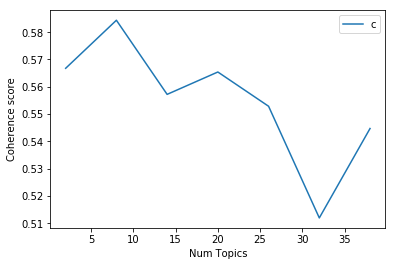

In [27]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5668
Num Topics = 8  has Coherence Value of 0.5844
Num Topics = 14  has Coherence Value of 0.5572
Num Topics = 20  has Coherence Value of 0.5654
Num Topics = 26  has Coherence Value of 0.5529
Num Topics = 32  has Coherence Value of 0.5119
Num Topics = 38  has Coherence Value of 0.5447


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here. (여기선 8이 제일 좋음.)

In [30]:
# Select the model and print the topics
optimal_model = model_list[1] # num topics = 8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.010*"writes" + 0.010*"organization" + 0.010*"lines" + 0.009*"article" + '
  '0.006*"would" + 0.006*"dont" + 0.005*"university" + 0.005*"one" + '
  '0.004*"like" + 0.004*"know"'),
 (1,
  '0.008*"lines" + 0.007*"organization" + 0.006*"article" + 0.006*"writes" + '
  '0.004*"one" + 0.004*"scsi" + 0.004*"like" + 0.003*"would" + 0.003*"get" + '
  '0.003*"time"'),
 (2,
  '0.008*"lines" + 0.008*"would" + 0.008*"organization" + 0.007*"writes" + '
  '0.006*"article" + 0.005*"like" + 0.005*"one" + 0.005*"dont" + 0.005*"think" '
  '+ 0.004*"know"'),
 (3,
  '0.007*"lines" + 0.006*"organization" + 0.004*"one" + 0.004*"get" + '
  '0.004*"car" + 0.004*"like" + 0.003*"file" + 0.003*"would" + 0.003*"new" + '
  '0.003*"article"'),
 (4,
  '0.006*"lines" + 0.005*"organization" + 0.004*"university" + 0.004*"games" + '
  '0.003*"team" + 0.003*"la" + 0.003*"one" + 0.003*"pts_pt" + 0.002*"article" '
  '+ 0.002*"game"'),
 (5,
  '0.640*"ax" + 0.046*"max" + 0.003*"pl" + 0.001*"qax" + 0.001*"ei" + '
  '

# 5. Application of LDA

## 5.1. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document.

In [31]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6663,"lines, organization, one, get, car, like, file...",From: (wheres my thing) Subject: WHAT car is t...
1,1,3.0,0.6381,"lines, organization, one, get, car, like, file...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,3.0,0.7988,"lines, organization, one, get, car, like, file...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,0.0,0.6089,"writes, organization, lines, article, would, d...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,3.0,0.9775,"lines, organization, one, get, car, like, file...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,1.0,0.9424,"lines, organization, article, writes, one, scs...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,0.0,0.5050,"writes, organization, lines, article, would, d...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,0.0,0.6397,"writes, organization, lines, article, would, d...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,6.0,0.9875,"people, one, would, said, dont, know, think, u...",Subject: Re: Dont more innocents die without t...
9,9,2.0,0.4859,"lines, would, organization, writes, article, l...",From: (Jon Livesey) Subject: Re: Genocide is C...


## 5.2. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9952,"writes, organization, lines, article, would, d...",From: (Foxvog Douglas) Subject: Re: Rewording ...
1,1.0,0.9970,"lines, organization, article, writes, one, scs...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
2,2.0,0.9976,"lines, would, organization, writes, article, l...",From: (James David) Subject: Plus minus stat O...
3,3.0,0.9993,"lines, organization, one, get, car, like, file...",From: (Landon C. Noll) Subject: 10th Internati...
4,4.0,0.9901,"lines, organization, university, games, team, ...",From: (Droopy) Subject: AHL final standings Or...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

## 5.3. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed.

In [33]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3.0,"lines, organization, one, get, car, like, file...",1723.0,0.1523
1,3.0,"lines, organization, one, get, car, like, file...",1112.0,0.0983
2,3.0,"lines, organization, one, get, car, like, file...",2247.0,0.1986
3,0.0,"writes, organization, lines, article, would, d...",1778.0,0.1572
4,3.0,"lines, organization, one, get, car, like, file...",408.0,0.0361
5,1.0,"lines, organization, article, writes, one, scs...",14.0,0.0012
6,0.0,"writes, organization, lines, article, would, d...",1638.0,0.1448
7,0.0,"writes, organization, lines, article, would, d...",2394.0,0.2116
8,6.0,"people, one, would, said, dont, know, think, u...",NaN,NaN
9,2.0,"lines, would, organization, writes, article, l...",NaN,NaN
